# Dati grezzi e funzioni matematiche nelle epidemie

In [2]:
import json
import requests
import urllib.request
import io
import datetime as dt

from IPython.display import display, Math, Latex, Markdown, clear_output, HTML

import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from tqdm.notebook import tqdm

from scipy.optimize import curve_fit
from scipy import stats
import numpy as np
import pandas as pd

In [3]:
display(
    Markdown(
        """
***

Max Pierini - {}

[info@maxpierini.it](info@maxpierini.it)

[nCoV website](https://maxpierini.it/ncov)

***       
        """.format(dt.datetime.now().strftime("%Y %m %d"))
    )
)


***

Max Pierini - 2020 04 25

[info@maxpierini.it](info@maxpierini.it)

[nCoV website](https://maxpierini.it/ncov)

***       
        

## Introduzione

I numero totale cumulativo di casi di contagio in un'epidemia segue tipicamente una curva di accrescimento.

In [4]:
def get_df(_data, country, what="Confirmed"):
    csv = "data,cases\n"
    for i, l in enumerate(_data[country][what]):
        n = _data[country][what][l]
        csv += f"{l},{n}"
        if i < len(_data[country][what]) - 1:
            csv += "\n"
    data = None
    data = pd.read_csv(io.StringIO(csv),
                         usecols=['data', 'cases'],
                         parse_dates=['data'],
                         index_col=['data'],
                         squeeze=True).sort_index()
    return data

In [5]:
def gompertz_func(x, a, b, k, e):
    exp = - np.exp(k * (b - x))    
    return a * np.exp(exp) + e

In [6]:
def logistic_func(x, a, b, k, e):
    d = k * (b - np.array(x))
    return (a / (1 + np.exp(d))) + e

In [7]:
def double_gompertz(x, a1, b1, k1, a2, b2, k2, e):
    exp1 = - np.exp(k1 * (b1 - x))
    g1 = a1 * np.exp(exp1)
    exp2 = - np.exp(k2 * (b2 - x))
    g2 = (a2 - a1) * np.exp(exp2)
    return g1 + g2 + e

In [8]:
def double_logistic(x, a1, b1, k1, a2, b2, k2, e):
    d1 = k1 * (b1 - np.array(x))
    l1 = a1 / (1 + np.exp(d1))
    d2 = k2 * (b2 - np.array(x))
    l2 = (a2 - a1) / (1 + np.exp(d2))
    return l1 + l2 + e

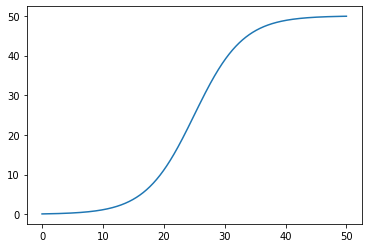

In [9]:
x = np.linspace(0, 50, 1000)
y = logistic_func(x, 50, 25, .25, 0)
plt.plot(x, y)
plt.show()

Le curve di accrescimento nella realtà sono però raramente sono così regolari. Esistono quindi differenti funzioni matematiche per descriverle.

Ad esempio, una curva può crescere più velocemente fino ad un certo, seguire una battuta di arresto e crescere meno rapidamente in seguito.

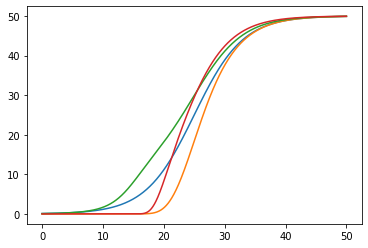

In [10]:
x = np.linspace(0, 50, 1000)
y1 = logistic_func(x, 50, 25, .25, 0)
y2 = gompertz_func(x, 50, 25, .25, 0)
y3 = double_logistic(x, 10, 15, .5, 50, 25, .25, 0)
y4 = double_gompertz(x, 20, 20, .5, 50, 25, .25, 0)
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.plot(x, y4)
plt.show()

Tutte queste 4 curve partono dal minimo di $0$ e arrivano al massimo di $50$ ma il "modo in cui ci arrivano" è evidentemente differente.

Anche per la curva di accrescimento dei contagi, è possibile utilizzare differenti formule matematiche per descrivere i dati e _interpolarli_ su una funzione che ne descriva al meglio l'andamento.

Proveremo dunque a interpolare i dati dei contagi totali di COVID-19 in Italia su 4 differenti funzioni matematiche semplici e osserveremo quali funzioni siano in grado descrivere al meglio i dati e come la scelta della funzione può influire sulle previsioni.

Le funzioni che useremo saranno:

- Funzione Logistica Semplice (logit)

$$ f(t) = \frac{a}{ 1 + \mathbf{e}^{k(b - t)} } +\varepsilon $$

- Funzione di Gompertz Semplice (gomp)

$$ g(t) = a \mathbf{e}^{ - \mathbf{e^{k(b - t)}} } +\varepsilon $$

- Funzione Logistica Doppia (doblogit)

$$ F(t) = \frac{a_1}{ 1 + \mathbf{e}^{k_1(b_1 - t)} } + \frac{a_2 - a_1}{ 1 + \mathbf{e}^{k_2(b_2 - t)} } +\varepsilon $$

- Funzione di Gompertz Doppia (dobgomp)

$$ G(t) = a_1 \mathbf{e}^{ - \mathbf{e^{k_1(b_1 - t)}} } + (a_2 - a_1) \mathbf{e}^{ - \mathbf{e^{k_2(b_2 - t)}} } + \varepsilon $$

Per i calcoli e le interpolazioni saranno usati i moduli `scipy`, `numpy` e `pandas` in ambiente `conda` con `python 3.7`.

## Casi totali e interpolazione

Diamo un primo sguardo ai dati grezzi dei contagi totali da COVID-19 in Italia.

In [11]:
def prepare_cases(
    cases, forecast=0, country=None,
    method=None, dolog=False):

    popt, pcov = None, None
    
    new_cases = cases.diff()
    max_new_cases = new_cases.argmax()

    if method == "dobgomp":
        p0=[
            cases[max_new_cases] * 2, max_new_cases, 1,
            max(cases), cases.size, 1,
            cases[0]
        ]
        print(p0)
        popt, pcov = curve_fit(
            double_gompertz,
            [i for i in range(cases.size)],
            cases,
            p0=p0, maxfev=8000, method="trf"
        )
        _results = double_gompertz([i for i in range(cases.size + forecast)], *popt)
        perr = np.sqrt(np.diag(pcov))
        _rSup = double_gompertz([i for i in range(cases.size + forecast)], *popt + perr)
        _rInf = double_gompertz([i for i in range(cases.size + forecast)], *popt - perr)
        
    elif method == "doblogit":
        p0=[
            cases[max_new_cases], max_new_cases, 1,
            max(cases), cases.size, 1,
            cases[0]
        ]
        popt, pcov = curve_fit(
            double_logistic,
            [i for i in range(cases.size)],
            cases,
            p0=p0, maxfev=8000, method="trf"
        )
        _results = double_logistic([i for i in range(cases.size + forecast)], *popt)
        perr = np.sqrt(np.diag(pcov))
        _rSup = double_logistic([i for i in range(cases.size + forecast)], *popt + perr)
        _rInf = double_logistic([i for i in range(cases.size + forecast)], *popt - perr)
        
    elif method == "gomp":
        p0=[
            cases[max_new_cases] * 2, max_new_cases, 1,
            cases[0]
        ]
        popt, pcov = curve_fit(
            gompertz_func,
            [i for i in range(cases.size)],
            cases,
            p0=p0, maxfev=8000, method="trf"
        )
        _results = gompertz_func([i for i in range(cases.size + forecast)], *popt)
        perr = np.sqrt(np.diag(pcov))
        _rSup = gompertz_func([i for i in range(cases.size + forecast)], *popt + perr)
        _rInf = gompertz_func([i for i in range(cases.size + forecast)], *popt - perr)
        
    elif method == "logit":
        p0=[
            cases[max_new_cases], max_new_cases, 1,
            cases[0]
        ]
        popt, pcov = curve_fit(
            logistic_func,
            [i for i in range(cases.size)],
            cases,
            p0=p0, maxfev=8000, method="trf"
        )
        _results = logistic_func([i for i in range(cases.size + forecast)], *popt)
        perr = np.sqrt(np.diag(pcov))
        _rSup = logistic_func([i for i in range(cases.size + forecast)], *popt + perr)
        _rInf = logistic_func([i for i in range(cases.size + forecast)], *popt - perr)
    
#    for i, p in enumerate(p0):
#        print(f"{i} : {p:.2f} - {popt[i]:.2f}")
#    print("-------------------------------------")
    
    forecast_index = pd.date_range(cases.index[0], cases.index[0] + pd.Timedelta(days=len(_results) - 1))
    
    _data = {"data": forecast_index, "valore": _results}
    results = pd.DataFrame(
        data=_data
    ).round()
    
    _cases = {"data": cases.index, "valore": cases.values}
    original = pd.DataFrame(
        data=_cases
    )
    
    _new_cases = {"data": cases.index, "valore": new_cases.values}
    new_cases = pd.DataFrame(
        data=_new_cases
    )

    __new_cases_results = results.diff()
    _new_cases_results = {"data": forecast_index, "valore": __new_cases_results["valore"]}
    new_cases_results = pd.DataFrame(
        data=_new_cases_results
    )
    __new_cases_results_sup = pd.Series(_rSup).diff()
    _new_cases_results_sup = {"data": forecast_index, "valore": __new_cases_results_sup.values}
    new_cases_results_sup = pd.DataFrame(
        data=_new_cases_results_sup
    )
    __new_cases_results_inf = pd.Series(_rInf).diff()
    _new_cases_results_inf = {"data": forecast_index, "valore": __new_cases_results_inf.values}
    new_cases_results_inf = pd.DataFrame(
        data=_new_cases_results_inf
    )
    
    logit1 = None
    logit2 = None
    if dolog:
        poptL1, pcovL1 = curve_fit(
            logistic_func,
            [i for i in range(max_new_cases)],
            cases[:max_new_cases],
            p0=[
                popt[3], max_new_cases, .1, 1
            ],
            method="trf", maxfev=8000
        )

        poptL2, pcovL2 = curve_fit(
            logistic_func,
            [i + max_new_cases for i in range(cases.size - max_new_cases)],
            cases[max_new_cases:],
            p0=[
                popt[3], max_new_cases, .1, 1
            ],
            method="trf", maxfev=8000
        )

        _logistic1 = logistic_func([i for i in range(cases.size + forecast)], *poptL1)
        forecast_index = pd.date_range(cases.index[0], cases.index[0] + pd.Timedelta(days=len(_logistic1) - 1))
        logit1 = pd.Series(
            data=_logistic1, index=forecast_index,
            name=f"{country} cases"
        ).round()

        _logistic2 = logistic_func([i for i in range(cases.size + forecast)], *poptL2)
        forecast_index = pd.date_range(cases.index[0], cases.index[0] + pd.Timedelta(days=len(_logistic2) - 1))
        logit2 = pd.Series(
            data=_logistic2, index=forecast_index,
            name=f"{country} cases"
        ).round()
    
    return original, results, popt, logit1, logit2, new_cases_results, new_cases, _rSup, _rInf, new_cases_results_sup, new_cases_results_inf

In [12]:
url = 'https://raw.githubusercontent.com/maxdevblock/covid-19-time-series/master/json/COVID-COUNTRIES.json'
with urllib.request.urlopen(url) as _url:
    _data = json.loads(_url.read().decode())

In [13]:
country = "Italy"
data = get_df(_data, country)

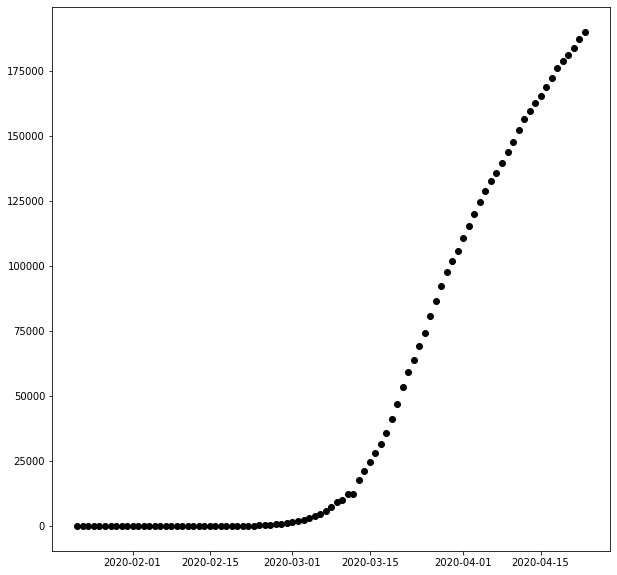

In [14]:
plt.figure(figsize=(10, 10))
plt.scatter(
    data.index, data,
    c="k"
)
plt.show()

e tentiamo di interpolare i dati noti sulle 4 funzioni scelte.

Vediamo i risultati:

[107156, 59, 1, 189973, 93, 1, 0]


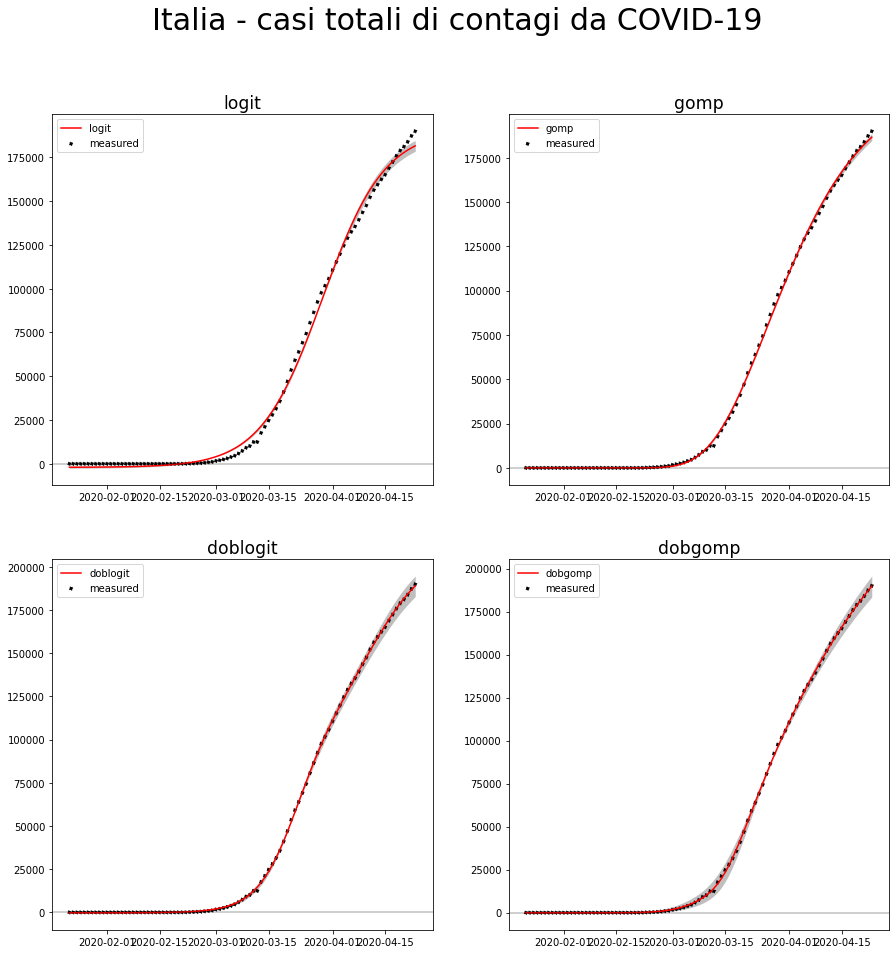

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for i, f in enumerate(['logit', 'gomp', 'doblogit', 'dobgomp']):
    original, interp, popt, _, _, _, _, rSup, rInf, _, _ = prepare_cases(data, forecast=0, country=country, method=f)
    axs.flat[i].scatter(
        original["data"],
        original["valore"],
        ls=":", s=10,
        label="measured", c="k"
    )
    axs.flat[i].plot(
        interp["data"],
        interp["valore"],
        c="r",
        label=f
    )
    axs.flat[i].fill_between(
        interp["data"],
        rSup, rInf,
        color='k',
        alpha=.25,
        lw=0,
    )
    axs.flat[i].legend(loc="upper left")
    axs.flat[i].set_title(f, fontsize="xx-large")
    axs.flat[i].axhline(0, c="k", alpha=.25)
fig.suptitle("Italia - casi totali di contagi da COVID-19", fontsize=30)
plt.show()

Notiamo che alcune funzioni sembrano descrivere molto meglio l'andamento della curva e alcune sembrerebbero equivalenti.

Sicuramente, la Logistica Semplice (logit) a causa della sua simmetria non è in grado di descrivere la curva analizzata.

Se proviamo però ad estendere la funzione interpolata fino a 120 giorni dopo l'ultimo dato noto, ci renderemo conto di ulteriori differenze tra le 4 curve.

[107156, 59, 1, 189973, 93, 1, 0]


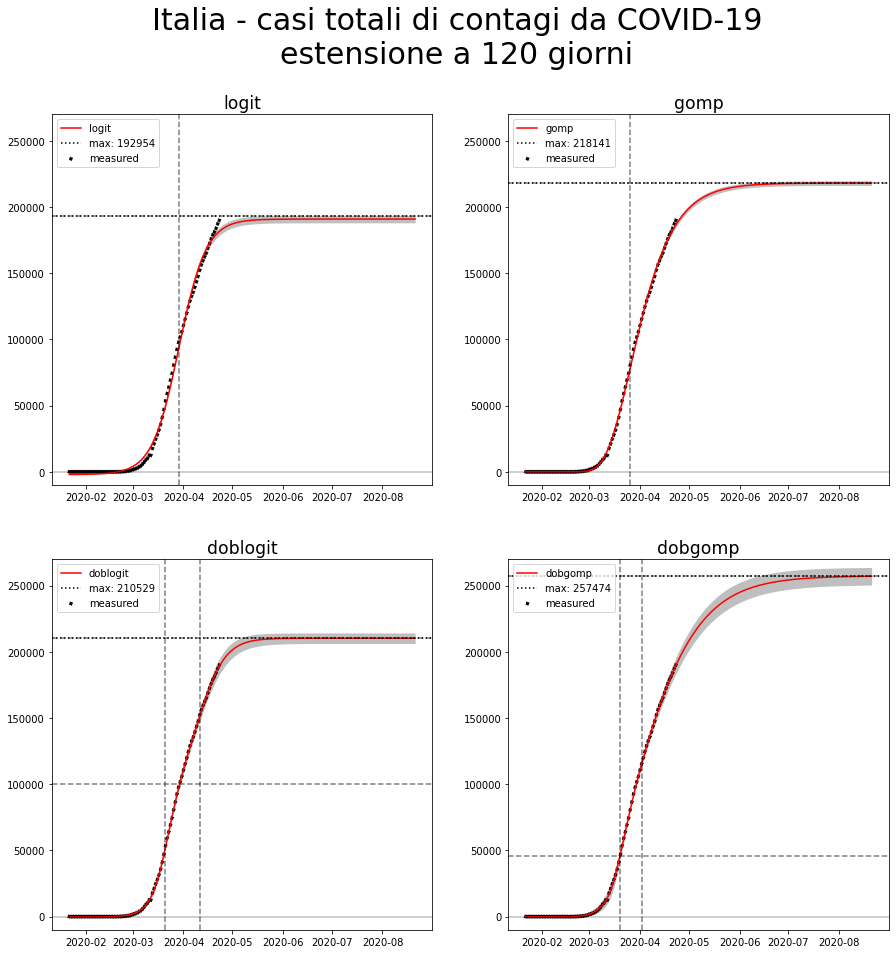

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for i, f in enumerate(['logit', 'gomp', 'doblogit', 'dobgomp']):
    original, interp, popt, _, _, _, _, rSup, rInf, _, _ = prepare_cases(data, forecast=120, country=country, method=f)
    axs.flat[i].scatter(
        original["data"],
        original["valore"],
        ls=":", s=10,
        label="measured", c="k"
    )
    axs.flat[i].plot(
        interp["data"],
        interp["valore"],
        c="r",
        label=f
    )
    axs.flat[i].fill_between(
        interp["data"],
        rSup, rInf,
        color='k',
        alpha=.25,
        lw=0,
    )
    axs.flat[i].axhline(popt[0], c="k", alpha=.5, ls="--")
    axs.flat[i].axvline(new_cases["data"][int(popt[1])], c="k", alpha=.5, ls="--")
    if len(popt) > 4:
        axs.flat[i].axhline(popt[3], c="k", alpha=.5, ls="--")
        axs.flat[i].axvline(new_cases["data"][int(popt[4])], c="k", alpha=.5, ls="--")
    axs.flat[i].axhline(max(popt), ls=":", c="k", label=f"max: {max(popt):.0f}")
    axs.flat[i].legend(loc="upper left")
    axs.flat[i].set_title(f, fontsize="xx-large")
    axs.flat[i].axhline(0, c="k", alpha=.25)
    axs.flat[i].set_ylim(-10000, 270000)
fig.suptitle("Italia - casi totali di contagi da COVID-19\nestensione a 120 giorni", fontsize=30)
plt.show()

Non solo risulta differente la curva di accrescimento ma anche il massimo previsto raggiunto dalla curva può cambiare di diverse migliaia di casi e differisce di mesi il giorno in cui il massimo sarà raggiunto.

Per comprendere meglio il differente accrescimento delle funzioni, proviamo ora interpolare i dati dei nuovi casi giornalieri.

In [17]:
## Nuovi casi totali e interpolazione

[107156, 59, 1, 189973, 93, 1, 0]


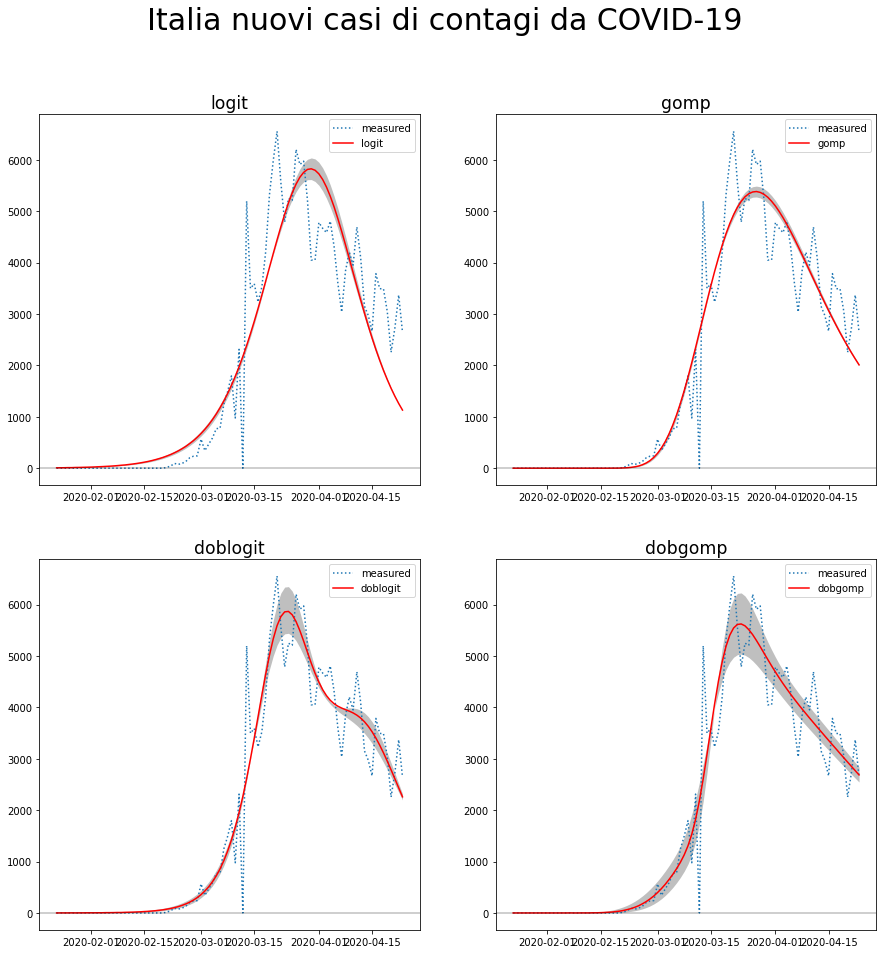

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for i, f in enumerate(['logit', 'gomp', 'doblogit', 'dobgomp']):
    _, _, popt, _, _, new_cases_i, new_cases, _, _, rSup, rInf = prepare_cases(data, forecast=0, country=country, method=f)
    axs.flat[i].plot(
        new_cases["data"],
        new_cases["valore"],
        ls=":",
        label="measured"
    )
    axs.flat[i].plot(
        new_cases_i["data"],
        new_cases_i["valore"],
        c="r",
        label=f
    )
    axs.flat[i].fill_between(
        rSup["data"],
        rSup["valore"], rInf["valore"],
        color='k',
        alpha=.25,
        lw=0,
    )
    # axs.flat[i].axhline(max(popt), ls=":", c="k", label=f"max: {max(popt):.0f}")
    axs.flat[i].legend(loc="upper right")
    axs.flat[i].set_title(f, fontsize="xx-large")
    axs.flat[i].axhline(0, c="k", alpha=.25)
    #news = new_cases_i.iloc[new_cases_i.index > new_cases.size]
    #zeros = news.iloc[news["valore"].values == 0]
    #zero = zeros["data"].values[0]
    #axs.flat[i].axvline(zero, c="k", alpha=.25)
fig.suptitle("Italia nuovi casi di contagi da COVID-19", fontsize=30)
plt.show()

[107156, 59, 1, 189973, 93, 1, 0]


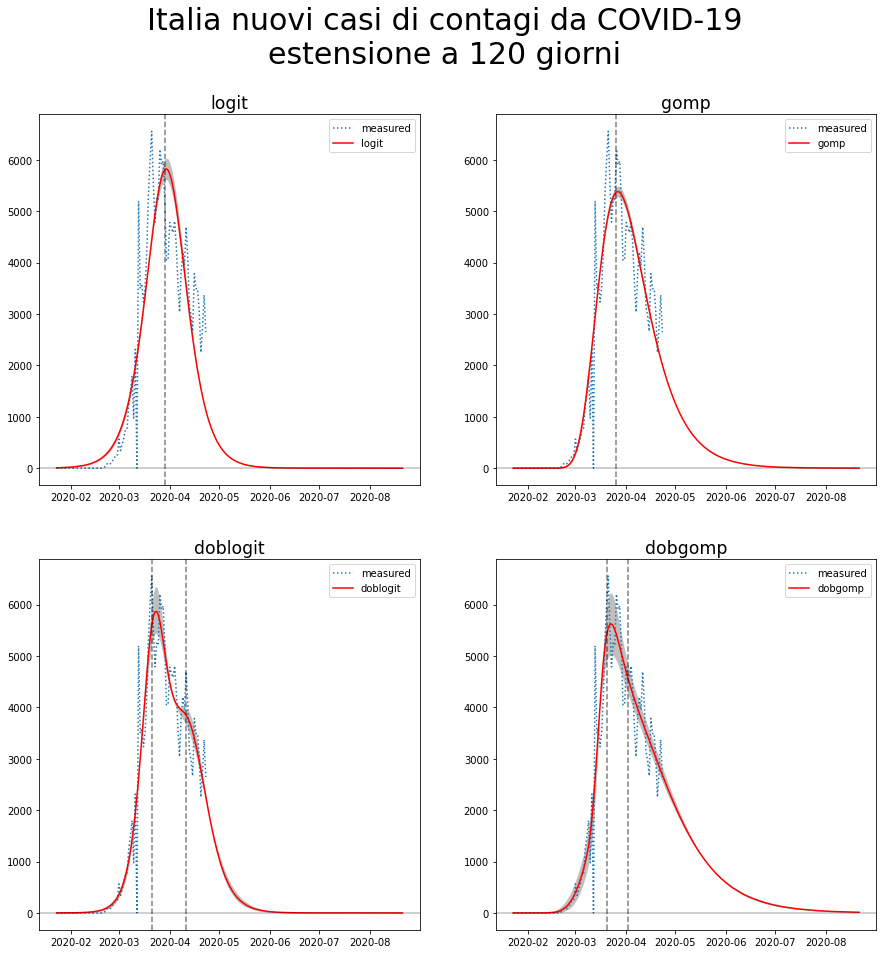

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for i, f in enumerate(['logit', 'gomp', 'doblogit', 'dobgomp']):
    _, _, popt, _, _, new_cases_i, new_cases, _, _, rSup, rInf = prepare_cases(data, forecast=120, country=country, method=f)
    axs.flat[i].plot(
        new_cases["data"],
        new_cases["valore"],
        ls=":",
        label="measured"
    )
    axs.flat[i].plot(
        new_cases_i["data"],
        new_cases_i["valore"],
        c="r",
        label=f
    )
    axs.flat[i].fill_between(
        rSup["data"],
        rSup["valore"], rInf["valore"],
        color='k',
        alpha=.25,
        lw=0,
    )
    # axs.flat[i].axhline(max(popt), ls=":", c="k", label=f"max: {max(popt):.0f}")
    #axs.flat[i].axhline(popt[0], c="k", alpha=.5, ls="--")
    axs.flat[i].axvline(new_cases["data"][int(popt[1])], c="k", alpha=.5, ls="--")
    if len(popt) > 4:
        #axs.flat[i].axhline(popt[3], c="k", alpha=.5, ls="--")
        axs.flat[i].axvline(new_cases["data"][int(popt[4])], c="k", alpha=.5, ls="--")
    axs.flat[i].legend(loc="upper right")
    axs.flat[i].set_title(f, fontsize="xx-large")
    axs.flat[i].axhline(0, c="k", alpha=.25)
    #news = new_cases_i.iloc[new_cases_i.index > new_cases.size]
    #zeros = news.iloc[news["valore"].values == 0]
    #zero = zeros["data"].values[0]
    #axs.flat[i].axvline(zero, c="k", alpha=.25)
fig.suptitle("Italia nuovi casi di contagi da COVID-19\nestensione a 120 giorni", fontsize=30)
plt.show()

In [121]:
country = "Italy"
data = get_df(_data, country, what="Recovered")

/Users/massimopierini/opt/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

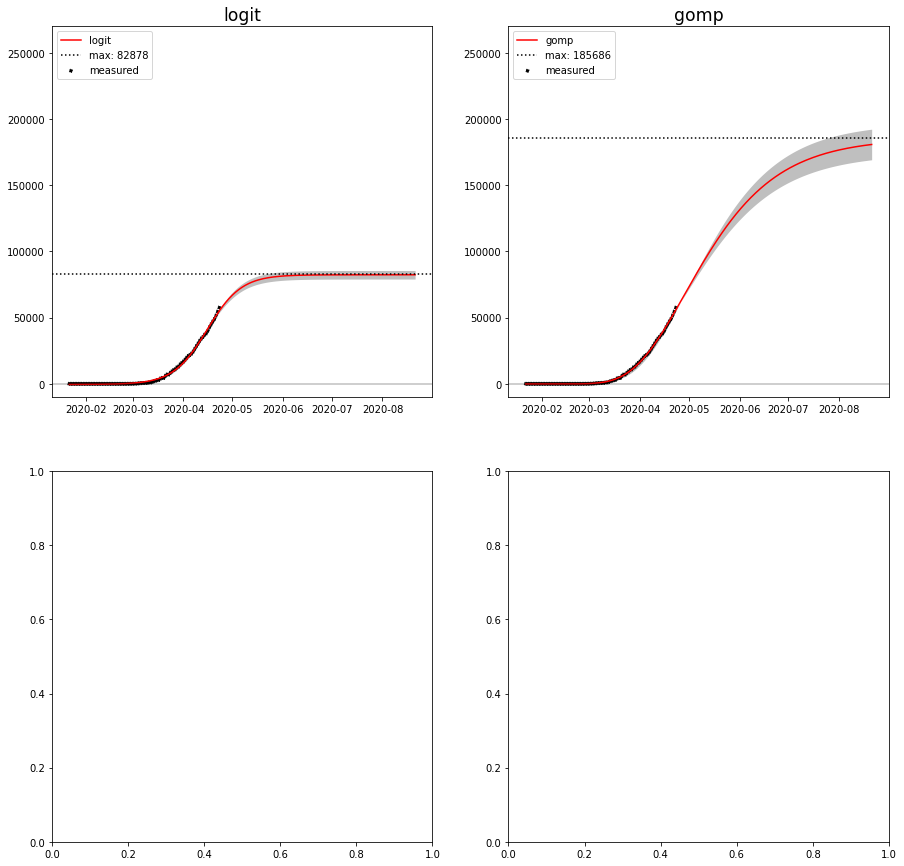

In [122]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for i, f in enumerate(['logit', 'gomp', 'doblogit', 'dobgomp']):
    original, interp, popt, _, _, _, _, rSup, rInf, _, _ = prepare_cases(data, forecast=120, country=country, method=f)
    axs.flat[i].scatter(
        original["data"],
        original["valore"],
        ls=":", s=10,
        label="measured", c="k"
    )
    axs.flat[i].plot(
        interp["data"],
        interp["valore"],
        c="r",
        label=f
    )
    axs.flat[i].fill_between(
        interp["data"],
        rSup, rInf,
        color='k',
        alpha=.25,
        lw=0,
    )
    axs.flat[i].axhline(max(popt), ls=":", c="k", label=f"max: {max(popt):.0f}")
    axs.flat[i].legend(loc="upper left")
    axs.flat[i].set_title(f, fontsize="xx-large")
    axs.flat[i].axhline(0, c="k", alpha=.25)
    axs.flat[i].set_ylim(-10000, 270000)
fig.suptitle("Italia - casi totali di contagi da COVID-19\nestensione a 120 giorni", fontsize=30)
plt.show()